In [1]:
import pandas as pd
import numpy as np
import math
import string
import copy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from collections import Counter
from tqdm import tqdm
from tensorflow_addons.metrics import F1Score
import warnings
import os
warnings.filterwarnings("ignore")

In [41]:
test_folds = {}

In [42]:
stfold = StratifiedKFold(n_splits=5, shuffle=True)
train_l = list()
val_l = list()
test_l = list()
maxlen = 100
cnt = 0
for train_index, test_index in stfold.split(data['comment'], data['label']):
    cnt += 1
    train = data.iloc[train_index]
    train_x, train_y = train['comment'], train['label']
    tmp = data.iloc[test_index]

    val, test = train_test_split(tmp, test_size=0.5, stratify=tmp['label'])    
    val_x, val_y = val['comment'], val['label']
    test_x, test_y = test['comment'], test['label']    
    
    train_x = keras.preprocessing.sequence.pad_sequences(train_x, maxlen=maxlen)
    val_x = keras.preprocessing.sequence.pad_sequences(val_x, maxlen=maxlen)
    test_x = keras.preprocessing.sequence.pad_sequences(test_x, maxlen=maxlen)
    
    test_folds[cnt] = (test_x, test_y)
    
    embed_dim = 64  # Embedding size for each token
    vocab_size = n_word_unique + 1
        
    
    inputs = layers.Input(shape=(maxlen, ))
    embedding_layer = layers.Embedding(input_dim = vocab_size, output_dim = embed_dim, input_length=maxlen)
    x = embedding_layer(inputs)
    x = layers.Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    x = layers.Dropout(0.2)(x)
    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    x = layers.concatenate([avg_pool, max_pool])
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model_path = "sigmoid_models/{itr:04}/".format(itr=cnt)
    checkpoint_path = model_path + "{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    !mkdir sigmoid_models
    !mkdir $model_path
    
    
    model.compile(tf.keras.optimizers.Adam(lr=0.001), "binary_crossentropy", metrics=["accuracy", 
                                                          tf.keras.metrics.AUC(name='auc')])
    
    
    #create checkpoint to save model
    #with best validation loss
    model.save_weights(checkpoint_path.format(epoch=0))

    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_auc', verbose=1,
            save_weights_only=True, save_best_only=True, mode='max')
    
    history = model.fit(
                        train_x, train_y, 
                        batch_size=128, epochs=10, 
                        validation_data=(val_x, val_y),
                        callbacks = [checkpoint]
                        )

    latest = tf.train.latest_checkpoint(checkpoint_dir)
    model.load_weights(latest)
    
    train_eval = model.evaluate(train_x, train_y)
    val_eval = model.evaluate(val_x, val_y)
    test_eval = model.evaluate(test_x, test_y)
    
    test_l.append(test_eval)
    val_l.append(val_eval)
    train_l.append(train_eval)

Epoch 1/10
62/63 [============================>.] - ETA: 0s - loss: 0.6806 - accuracy: 0.5685 - auc: 0.6085
Epoch 00001: val_auc improved from -inf to 0.82904, saving model to sigmoid_models/0001/0001.ckpt
63/63 [==============================] - 2s 35ms/step - loss: 0.6803 - accuracy: 0.5706 - auc: 0.6095 - val_loss: 0.6565 - val_accuracy: 0.7370 - val_auc: 0.8290
Epoch 2/10
61/63 [============================>.] - ETA: 0s - loss: 0.5469 - accuracy: 0.8143 - auc: 0.9290
Epoch 00002: val_auc improved from 0.82904 to 0.94149, saving model to sigmoid_models/0001/0002.ckpt
63/63 [==============================] - 2s 31ms/step - loss: 0.5431 - accuracy: 0.8159 - auc: 0.9292 - val_loss: 0.4197 - val_accuracy: 0.8530 - val_auc: 0.9415
Epoch 3/10
61/63 [============================>.] - ETA: 0s - loss: 0.2387 - accuracy: 0.9270 - auc: 0.9834
Epoch 00003: val_auc improved from 0.94149 to 0.96129, saving model to sigmoid_models/0001/0003.ckpt
63/63 [==============================] - 2s 29ms/ste

In [43]:
test_l = np.array(test_l)
val_l = np.array(val_l)
train_l = np.array(train_l)

print("test avg loss: ", np.mean(test_l[:, 0]), "+/-" ,np.std(test_l[:, 0]))
print("test avg acc: ", np.mean(test_l[:, 1]),  "+/-" ,np.std(test_l[:, 1]))
print("test avg auc: ", np.mean(test_l[:, 2]),  "+/-" ,np.std(test_l[:, 2]))

print('\n')


print("val avg loss: ", np.mean(val_l[:, 0]), "+/-" ,np.std(val_l[:, 0]))
print("val avg acc: ", np.mean(val_l[:, 1]),  "+/-" ,np.std(val_l[:, 1]))
print("val avg auc: ", np.mean(val_l[:, 2]),  "+/-" ,np.std(val_l[:, 2]))


print('\n')


print("train avg loss: ", np.mean(train_l[:, 0]), "+/-" ,np.std(train_l[:, 0]))
print("train avg acc: ", np.mean(train_l[:, 1]),  "+/-" ,np.std(train_l[:, 1]))
print("train avg auc: ", np.mean(train_l[:, 2]),  "+/-" ,np.std(train_l[:, 2]))

test avg loss:  0.25788824558258056 +/- 0.011241072431136076
test avg acc:  0.9120000004768372 +/- 0.004335904090033408
test avg auc:  0.9509644269943237 +/- 0.0038544363434240086


val avg loss:  0.24787272810935973 +/- 0.012558624507681665
val avg acc:  0.9136000037193298 +/- 0.008284929910939202
val avg auc:  0.956169581413269 +/- 0.004397399684679076


train avg loss:  0.03287178799510002 +/- 0.012644663460625916
train avg acc:  0.996399986743927 +/- 0.0023735506675340926
train avg auc:  0.9994417667388916 +/- 0.0002719557126220634


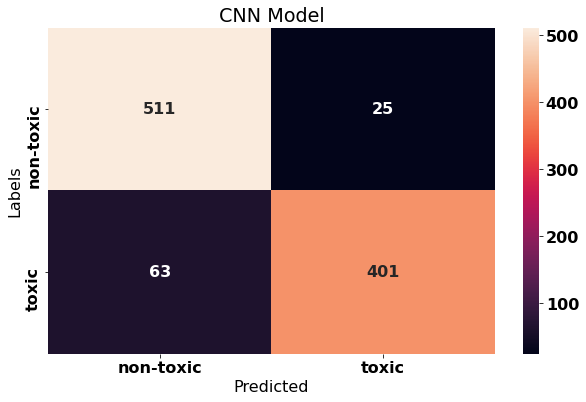

In [44]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd 
from sklearn.metrics import confusion_matrix

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
pred = np.array([model.predict(test_folds[5][0]) > 0.5], dtype=int).ravel()
cm = confusion_matrix(test_folds[5][1].values, pred)
cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10, 6))

sns.heatmap(cm,
            fmt = 'd',
            annot=True)


ax = plt.subplot()
ax.set_xlabel('Predicted')
ax.set_ylabel('Labels')
ax.xaxis.set_ticklabels(['non-toxic', 'toxic'])
ax.yaxis.set_ticklabels(['non-toxic', 'toxic'])
ax.set_title('CNN Model')
plt.show()